In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def get_truncated_normal(N, mean=0, sd=1, low=0, upp=np.inf):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(N)

class Agent:
    def __init__(self, R, I, E):
        self.threshold = 1. # T_1j（p.s. about initial value is in p.740）
        self.share_of_resource = R # R_j (share of the total resources N)
        self.interest = I # I_j (interest in public goods)
        self.learning_rate = E # E_j (learning rate)
        self.is_volunteer = False # V_1j
        self.share = 0 # S_ij 
        self.previous_share = 0 # S_(i-1)j
        self.outcome = 0

    def make_decision(self, pi, M=5):
        prob = 1 / (1 + np.exp((self.threshold - pi)*M)) # P_j (probability of participation): formula 1
        self.is_volunteer = random.choices([True, False], weights=[prob, 1-prob], k=1)[0] # V_ij
    
    def learn(self, S_max, L, N, J):
        self.set_contribution(N)
        self.set_share_of_public_good(L, N, J)
        self.set_standardized_outcome(S_max)
        self.update_threshold()

    def set_contribution(self, N):
        self.contribution = self.share_of_resource * N * self.is_volunteer # C_ij (the agent's contribution in this iteration): formula 2

    def set_share_of_public_good(self, L, N, J):
        self.previous_share = self.share
        self.share = (L * N * self.interest) / N**(1-J) - self.contribution # S_ij (share of the pulic goods going to this agent): formula 4

    def set_standardized_outcome(self, S_max):
        self.outcome =  self.learning_rate * (2*self.share-self.previous_share) / (3 * abs(S_max)) # O_ij: formula 5

    def update_threshold(self):
        if self.outcome != 0:
            reward = self.outcome * (1 - (1-self.threshold)**(1/abs(self.outcome))) 
            punishment = self.outcome * (1 - (self.threshold)**(1/abs(self.outcome))) 

            if self.is_volunteer and self.outcome > 0: # Vij = 1 & Oij > 0
                next_threshold = self.threshold - reward
            elif not self.is_volunteer and self.outcome < 0: # Vij = 0 & Oij < 0
                next_threshold = self.threshold + reward
            elif self.is_volunteer and self.outcome < 0: # Vij = 1 & Oij < 0
                next_threshold = self.threshold - punishment
            elif not self.is_volunteer and self.outcome > 0: # Vij = 0 & Oij > 0
                next_threshold = self.threshold + punishment

            self.threshold = max(0, min(next_threshold, 1)) # 0 <= threshold <= 1

class Lattice:
    def __init__(self, N, X, J, net_type, distribution):
        self.agent_num = N 
        self.agents = []
        self.X = X # constant determining the range of L
        self.J = J # jointness of supply
        self.net_type = net_type # "serial"; "parallel"
        self.t = 0 # time (number of iteration)

        if distribution == None:
            R = get_truncated_normal(N, mean=1, sd=.5) 
            I = get_truncated_normal(N, mean=1, sd=.5)
            E = get_truncated_normal(N, mean=.5, sd=.5, low=0, upp=1)
        else:
            R, I, E = distribution[0], distribution[1], distribution[2]

        R = R/sum(R)

        for i in range(N):
            self.agents.append(Agent(R[i], I[i], E[i]))

    def one_round(self):
        self.t += 1

        # 1. decision algro
        r = list(range(self.agent_num))
        random.shuffle(r)
        for i in r:
            agent = self.agents[i]
            pi = self.get_agent_pi()
            agent.make_decision(pi)

        # 2. learning
        for agent in self.agents:

            # S_max = self.get_production_level() * self.agent_num * max([a.interest for a in self.agents]) / (self.agent_num ** (1-self.J))
            S_max =  self.get_production_level() * self.agent_num * 1 / (self.agent_num ** (1-self.J))
            if S_max == 0: S_max = 10**-20

            agent.learn(S_max, self.get_production_level(), self.agent_num, self.J)

    def get_agent_pi(self):
        if self.net_type == "parallel":
            return 0.5
        elif self.net_type == "serial":
            return self.get_participation_rate()

    def get_production_level(self):
        pi = self.get_participation_rate()
        return 1/(1+np.exp((.5-pi)*10)) - ((1-self.X)/2) # L (level of production): formula 3

    def get_participation_rate(self):
        return sum([a.is_volunteer for a in self.agents]) / self.agent_num # pi


def simulate(net_type, N, J, X, round_num, n_trial, distribution=None):
    log = []
    for _ in range(n_trial):
        myLattice = Lattice(N, X, J, net_type, distribution)
        trial_log = [myLattice.get_participation_rate()]
        for _ in range(round_num):
            myLattice.one_round()
            trial_log.append(myLattice.get_participation_rate())
        log.append(trial_log)
    return log

# Figure 1.

#### (一) 原文設定

#### (二) 拉長時間

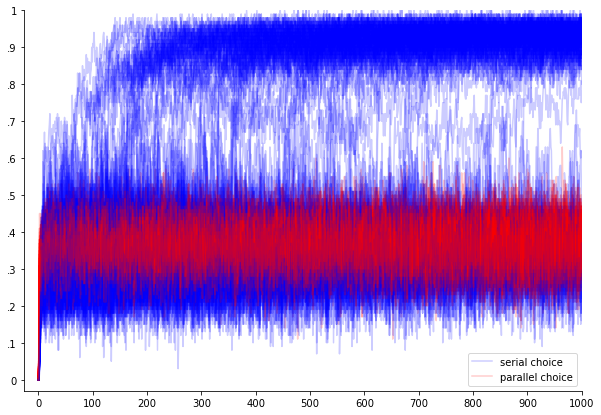

In [36]:
random.seed(123)
np.random.seed(123)

N = 100
J = .5
X = 0


round_num = 1000
n_trial = 100

log_serial = simulate("serial", N, J, X, round_num, n_trial)
log_parallel = simulate("parallel", N, J, X, round_num, n_trial)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for trial in range(n_trial):
    ax.plot(log_serial[trial], label='serial choice', color='blue', alpha=.2)
    ax.plot(log_parallel[trial], label='parallel choice', color='red', alpha=.2)

ax.set_ylim(-.03, 1)
ax.set_xlim(-27, round_num)
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_xticks(np.arange(0, 1001, 100))
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.strip('0').rstrip('.') if x != 0 else 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

fig.set_facecolor('white')
plt.savefig('FIG1-2.png')

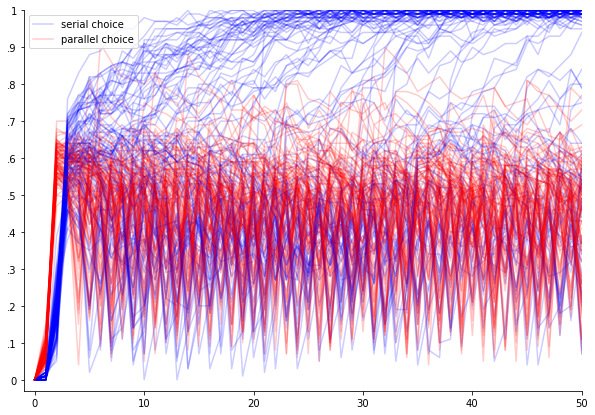

In [34]:
random.seed(123)
np.random.seed(123)

N = 100
J = .5
X = 0

round_num = 50
n_trial = 100

R = get_truncated_normal(N, mean=1, sd=.1) 
I = get_truncated_normal(N, mean=1, sd=.1)
E = get_truncated_normal(N, mean=1, sd=.1, low=0, upp=1)
distribution = [R, I, E]

log_serial = simulate("serial", N, J, X, round_num, n_trial, distribution)
log_parallel = simulate("parallel", N, J, X, round_num, n_trial, distribution)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for trial in range(n_trial):
    ax.plot(log_serial[trial], label='serial choice', color='blue', alpha=.2)
    ax.plot(log_parallel[trial], label='parallel choice', color='red', alpha=.2)

ax.set_ylim(-.03, 1)
ax.set_xlim(-1, round_num)
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_xticks(np.arange(0, 51, 10))
ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.3f}'.strip('0').rstrip('.') if x != 0 else 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

fig.set_facecolor('white')
plt.savefig('FIG1-3-2.png')

In [5]:
# log_t_all = []
# log_t_v = []
# log_t_f = []
# for _ in range(round_num):
#     myLattice.one_round()
#     log.append(myLattice.get_participation_rate())
#     log_t_all.append(sum([a.threshold for a in myLattice.agents]) / len(myLattice.agents))
#     v = [a.threshold for a in myLattice.agents if a.is_volunteer]
#     f = [a.threshold for a in myLattice.agents if not a.is_volunteer]
#     if len(v) != 0: log_t_v.append(sum(v)/len(v))
#     else: log_t_v.append(np.nan)
#     if len(f) != 0: log_t_f.append(sum(f)/len(f))
#     else: log_t_f.append(np.nan)

# ax.plot(log_t_all, label="All")
# ax.plot(log_t_v, label="Volunteer")
# ax.plot(log_t_f, label="Free-reider")
# plt.legend()

## 文章沒寫清楚的地方
- "At each iteration, the decision algorithm loop untion no further contributions are triggered." (p.735) 意思?
- R, I, E 的「常態」分佈為何？
- Smax 的計算公式為何？等於 0 （x=1, pi=.5）時如何處理？
- 我自己不確定的地方： parallel choive 的設定？